In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *
from paraparticle_utils import *

import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
N = 3
M = 3
V = 1

times = np.linspace(0, 500, 5000)
initial_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0)
quench_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 3)

hamiltonians = [initial_hamiltonian] + [quench_hamiltonian] * (len(times) - 1)
total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)

eigenvalues, eigenvectors, total_ns = exact_diagonalize_with_total_paraparticle_number_symmetry(initial_hamiltonian, total_paraparticle_number_operator)
initial_state = eigenvectors[1]

results = simulate_hamiltonian_time_evolution(hamiltonians, times, initial_state)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = results


Text(0, 0.5, 'Total Paraparticle Number')

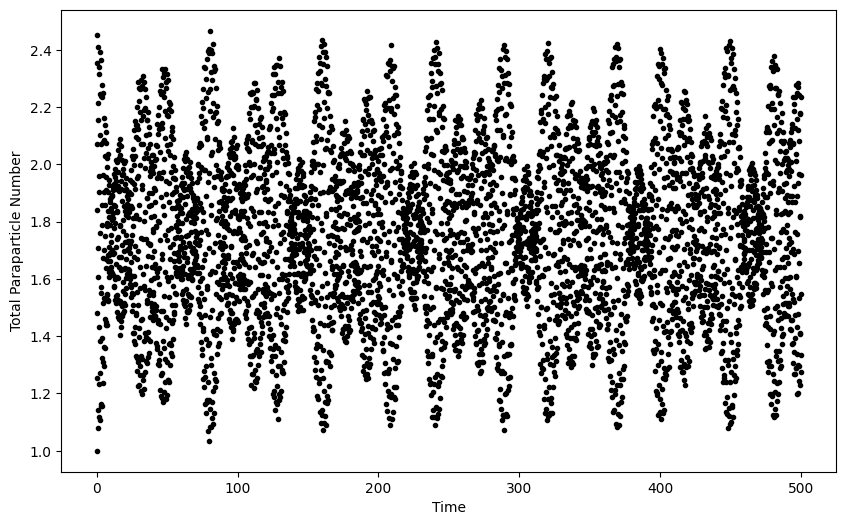

In [3]:
fig, ax  = plt.subplots(figsize=(10, 6))


for i, wavefunction in enumerate(time_evolved_wavefunctions):
    paraparticle_number = wavefunction.conj().T @ total_paraparticle_number_operator @ wavefunction
    ax.plot(times[i], paraparticle_number, '.k')

ax.set_xlabel('Time')
ax.set_ylabel('Total Paraparticle Number')

In [4]:
N = 3
M = 3
V = 1

total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
initial_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0)
eigenvalues, eigenvectors, total_ns = exact_diagonalize_with_total_paraparticle_number_symmetry(initial_hamiltonian, total_paraparticle_number_operator)

perturb_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0.1)
times = np.linspace(0, 1000, 1000)
hamiltonians = [perturb_hamiltonian for t in times]

initial_state = eigenvectors[0]

results = simulate_hamiltonian_time_evolution(hamiltonians, times, initial_state)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = results

exp_values = []
for state in time_evolved_wavefunctions:
    exp_values += [state.conj().T @ total_paraparticle_number_operator @ state]

Text(0.5, 0, 't')

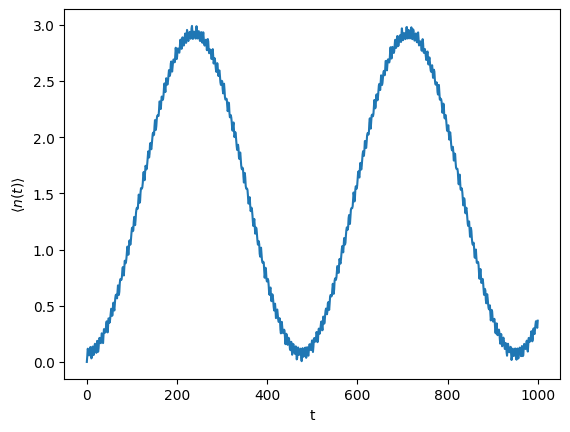

In [5]:
fig, ax = plt.subplots()
ax.plot(times, exp_values, '-')
ax.set_ylabel("$\langle n (t) \\rangle$")
ax.set_xlabel("t")


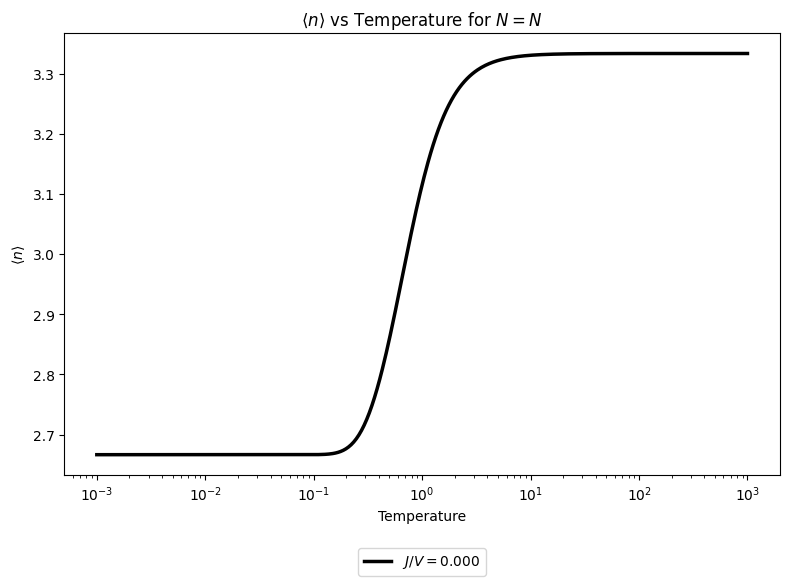

In [ ]:
N = 5
M = 3
V = 1
mu_V_ratio = 0
J_V_ratios = [0]

temperatures = np.logspace(-3, 3, 500)
betas = 1 / temperatures
colors = get_cmap("gist_rainbow", len(J_V_ratios))

states, _ = enumerate_states(N, M)

fig, ax = plt.subplots(figsize=(8,6))

total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
construct_site_paraparticle_number_operator(N, site_index = site_index)

for i, J_V_ratio in enumerate(J_V_ratios):
    
    exp_values = []
    hamiltonian = construct_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        exp_value = calculate_finite_temperature_expectation_value(total_paraparticle_number_operator, beta, eigenvalues, eigenvectors)                                                  
        exp_values.append(exp_value)
        
    if J_V_ratio == 0:
        color = "k"
        linewidth = 2.5
    else:
        color = colors(i)
        linewidth = 1.25
    
    ax.plot(temperatures, exp_values, color=color, linewidth = linewidth, label=f"$J/V = {J_V_ratio:.3f}$")

ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("$\langle n \\rangle $")
ax.set_title("$\langle n \\rangle$ vs Temperature for $N={N}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()

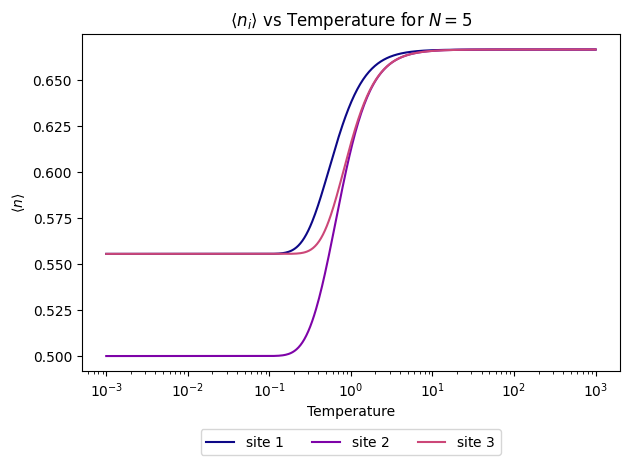

In [28]:
N = 5
M = 3
V = 1

fig, ax = plt.subplots()
colors = get_cmap("plasma", len(range(N)))

for idx, site_index in enumerate(range(N//2+1)):
    operator = construct_site_paraparticle_number_operator(N, site_index = site_index+1)

    exp_values = []
    hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    for beta in betas:
        exp_value = calculate_finite_temperature_expectation_value(operator, beta, eigenvalues, eigenvectors)                                                  
        exp_values.append(exp_value)
    
    ax.plot(temperatures, exp_values, color = colors(idx), label=f"site ${site_index+1}$")
    
ax.set_xscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("$\langle n \\rangle $")
ax.set_title(f"$\langle n_i \\rangle$ vs Temperature for $N={N}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=5)
plt.tight_layout()
plt.show()